<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - Linear Regression
    </div>
<br><br>
<font size=4>
   **Name**: Mohammad Mahdi<br>
   **Student ID**: 98105557<br> <br>

<font face="Times New Roman" size=4><div dir=ltr>
# Problem 1: Linear Regression Model (40 + 30 optional points)
According to <a href="https://github.com/asharifiz/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_02_Classical_Models/Linear%20regression.ipynb"><font face="Roboto">Linear Regression Notebook</font></a>, train a linear regression model on an arbitrary dataset. Explain your chosen dataset and split your data into train and test sets, then predict values for the test set using your trained model. Try to find the best hyperparameters for your model. (Using Lasso Regression, Ridge Regression or Elastic Net and comparing them will have extra optional points)
<br> Explain each step of your workflow.

In [59]:
# libraries
import pandas as pd
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet

### loading dataset
This dataset is Tesla's stock from 2010 to 2020. it has some columns of opening price or highest and lowest price of the day. we try to predict closing/the last price of the stock based on the other features.


In [60]:
df = pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [61]:
df = df.drop(['Date'],axis=1)
y = df["Close"]
# y = np.log(y)
X = df.drop(["Close","Adj Close", "Volume"], axis=1)
X = X.to_numpy()
y = y.to_numpy()
y = y[:, np.newaxis]

### Split dataset to train and test

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Regression mdoel closed form

In [63]:
class RegressionCloseForm:
    def __init__(self):
        self.W = None
              
    def train(self, X_train, y):
        X = np.append(np.ones((X_train.shape[0], 1)), X_train , axis=1)
        self.W = np.dot((np.linalg.inv(np.dot(X.T,X))), np.dot(X.T,y))
    
    def predict(self, X_test):
        X = np.append(np.ones((X_test.shape[0], 1)), X_test , axis=1)
        return np.dot(X, self.W)
    
    def mse_loss(self, pred, real):
        diff = pred - real
        return np.sum(diff * diff) / diff.size

In [64]:
model = RegressionCloseForm()
model.train(X_train, y_train)
predictions = model.predict(X_test)
model.mse_loss(y_test, predictions)

4.33599499201486

### Vanilla Linear regression with sklearn

In [65]:
regr_model = linear_model.LinearRegression()
regr_model.fit(X_train, y_train)

LinearRegression()

MSE error on training data

In [66]:
predictions_train = regr_model.predict(X_train)
mean_squared_error(y_train, predictions_train)

4.072263443853506

MSE error on test data

In [67]:
predictions = regr_model.predict(X_test)
mean_squared_error(y_test, predictions)

4.335994992006454

In [68]:
# Evaluation of model regression score function. it shows our model works well
regr_model.score(X_test, y_test)

0.9997146194870747

Compare predicted values with real ones

In [69]:
comparison = pd.DataFrame({'Predicted':predictions.flatten(),'Real':y_test.flatten(), 'differnece':np.abs(predictions - y_test).flatten()})
comparison

,Predicted,Real,differnece
0,31.401864,31.490000,0.088136
1,24.501496,24.650000,0.148504
2,278.907767,279.760010,0.852243
3,330.569260,328.200012,2.369248
4,262.135069,259.320007,2.815062
...,...,...,...
479,174.848046,179.000000,4.151954
480,254.584768,251.860001,2.724767
481,24.871589,25.059999,0.188410
482,341.160407,345.660004,4.499597


So it seems that our model worked well.

In [70]:
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=1, max_iter=10000)
elasticnet_model.fit(X_train, y_train)
predictions = elasticnet_model.predict(X_test)
mean_squared_error(y_test, predictions)

4.4132143024281705

### regression model from scratch

In [71]:
class RegressionModel:
    
    def __init__(self, lr, number_of_epochs, regularization=None):
        self.m = None # samples
        self.n = None # features
        self.W = None # weight
        self.regularization = regularization # penalty object
        self.lr = lr # learning rate
        self.epoch = number_of_epochs # iteration
        self.train_mean = None
        self.train_std = None
        
    def __calculate_cost(self, y, y_pred):
        cost = (1 / (2 * self.m)) * np.sum(np.square(y_pred-y))
        if self.regularization:
            return cost + self.regularization(self.W) 
        return cost
    
    def __initialize(self, X):
        X2 = np.insert(X, 0, 1, axis=1)
        self.m, self.n = X2.shape
        self.W = np.random.rand(self.n, 1)
        return X2
    
    def __update_weights(self, X, y, y_pred):
        dw = np.dot(X.T, (y_pred - y)) / self.m
        if self.regularization:
            dw += self.regularization.derivation(self.W)
        
        self.W -= self.lr * dw
    
    def __feature_scaling(self, data, is_training = False):
        data2 = data.copy()
        number_of_columns = data.shape[1]
        if is_training:
            self.train_mean = [0] * number_of_columns
            self.train_std = [0] * number_of_columns
        for i in range(number_of_columns):
            if is_training:
                self.train_mean[i] = np.mean(data2[:,i])
                self.train_std[i] = np.std(data2[:,i])
            data2[:,i] = (data2[:,i] - self.train_mean[i]) / self.train_std[i]
        return data2
        
    def fit(self, X_train, y_train, logging=True):
        if isinstance(X_train, pd.core.frame.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.core.frame.DataFrame):
            y_train = y_train.to_numpy()
        X = self.__feature_scaling(X_train, is_training=True)
        
        X = self.__initialize(X)
        y = y_train.reshape(self.m, -1)
        for e in range(1, self.epoch+1):
            y_pred = np.dot(X, self.W)
            cost = self.__calculate_cost(y, y_pred)
            self.__update_weights(X, y, y_pred)
            if logging and e % 10000 == 0:
                print(f"The Cost in iteration {e}-----> {cost} :)")

    def predict(self, X_test):
        if isinstance(X_test, pd.core.frame.DataFrame):
            X_test = X_test.to_numpy()
        X_test2 = self.__feature_scaling(X_test)
        X_test2 = np.insert(X_test2, 0 , 1, axis= 1)
        return np.dot(X_test2, self.W) 

In [72]:
def mse_loss(pred, real):
    diff = pred - real
    return np.sum(diff * diff) / diff.size

In [73]:
reg_model_custom = RegressionModel(lr=0.1, number_of_epochs=50000)
reg_model_custom.fit(X_train, y_train)
predictions = reg_model_custom.predict(X_test)
mse_loss(y_test, predictions)

The Cost in iteration 10000-----> 3.837495970640228 :)
The Cost in iteration 20000-----> 2.6985138548146645 :)
The Cost in iteration 30000-----> 2.291529583108941 :)
The Cost in iteration 40000-----> 2.137841325696809 :)
The Cost in iteration 50000-----> 2.0774798198803253 :)


4.482488375698887

In [78]:
best_loss = np.inf
best_lr = None
lr_list = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,8e-2,1e-1,2e-1,5e-1]
for lr in tqdm.tqdm(lr_list):
    reg_model_custom = RegressionModel(lr=lr, number_of_epochs=50000)
    reg_model_custom.fit(X_train, y_train, logging=False)
    predictions = reg_model_custom.predict(X_test)
    loss = mse_loss(y_test, predictions)
    if loss < best_loss:
        best_loss = loss
        best_lr = lr
print(f'best learning rate: {best_lr}')
print(f'best loss: {best_loss}')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]

best learning rate: 0.5
best loss: 4.336010209148474


In [79]:
class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, w):
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(w))
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(w))
        return l1_contribution + l2_contribution

    def derivation(self, w):
        l1_derivation = self.l * self.l_ratio * np.sign(w)
        l2_derivation = self.l * (1 - self.l_ratio) * w
        return l1_derivation + l2_derivation

In [80]:
class LassoRegression(RegressionModel):
        def __init__(self, lr, number_of_epochs, l):
            regularization = ElasticPenalty(l, l_ratio=1) # penalty object
            super().__init__(lr, number_of_epochs, regularization)

            
class RidgeRegression(RegressionModel):
        def __init__(self, lr, number_of_epochs, l):
            regularization = ElasticPenalty(l, l_ratio=0) # penalty object
            super().__init__(lr, number_of_epochs, regularization)

            
class ElasticNet(RegressionModel):
        def __init__(self, lr, number_of_epochs, l = 0.1, l_ratio = 0.5):
            regularization = ElasticPenalty(l, l_ratio) # penalty object
            super().__init__(lr, number_of_epochs, regularization)

In [81]:
lasso_model = LassoRegression(lr=5e-2, number_of_epochs=25000, l = 0.1)
lasso_model.fit(X_train, y_train)
predictions = lasso_model.predict(X_test)
mse_loss(y_test, predictions)

The Cost in iteration 10000-----> 35.50222546152582 :)
The Cost in iteration 20000-----> 34.59132991822705 :)


7.894000907362028

In [85]:
ridge_model = RidgeRegression(lr=5e-2, number_of_epochs=30000, l = 0.1)
ridge_model.fit(X_train, y_train)
predictions = ridge_model.predict(X_test)
mse_loss(y_test, predictions)

The Cost in iteration 10000-----> 1810.1660024170287 :)
The Cost in iteration 20000-----> 1810.1660024170287 :)
The Cost in iteration 30000-----> 1810.1660024170287 :)


306.76062550162806

In [86]:
losses = []
for i in tqdm.tqdm(range(11)):
    parameters = {
        "l_ratio" : i * 0.1,
        "l" : 0.1,
        "lr" : 5e-2,
        "number_of_epochs" : 10000
    }
    model = ElasticNet(**parameters)
    model.fit(X_train, y_train, logging=False)
    predictions = model.predict(X_test)   
    losses.append(mse_loss(y_test, predictions))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.24it/s]


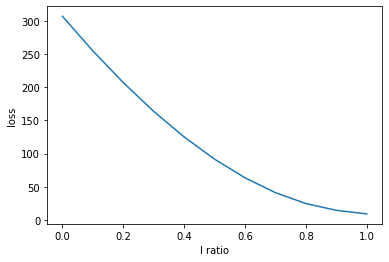

In [87]:
x = [i * 0.1 for i in range(11)]
y = losses
plt.plot(x, y)
plt.xlabel('l ratio')
plt.ylabel('loss')
plt.show()